In [ ]:
#!python -m spacy download pl_core_news_lg
import pandas as pd
import numpy as np
import language_tool_python
from datetime import datetime
import re
from functions import *
from evaluation_functions import *
import pandas as pd
tool = language_tool_python.LanguageTool('pl')

## Introduction


* The following code aims at using pretrained polish BERT models for tweet classifications. 
* Dataset has been labeled to classify all netrual/not relevant tweets as neutral.
* This allows for filtering out noise - tweets that aren't aimed at specific company.
* Models used were chose based on the KLEJ bechmark t(https://klejbenchmark.com/leaderboard/).

### Preparing training dataset

In [2]:
# dataset_1 = pd.read_csv('TrainingData/annotation_dataset - general_label.csv',index_col=0)
# dataset_2 = pd.read_csv('TrainingData/annotation_dataset - annotation_second_round_labeled.csv',index_col=0)

# dataset_1 = dataset_1[['text','Overall']]
# dataset_1 =  dataset_1.rename(columns={'Overall':'labels'})

# dataset_2 = dataset_2[['text','label']]
# dataset_2 =  dataset_2.rename(columns={'label':'labels'})

In [3]:
all_columns = pd.read_csv(r'TrainingData\dataset_labeled.csv', nrows=0).columns.tolist()

columns_to_exclude = ['Unnamed: 0','Unnamed: 0.1' , 'Unnamed: 0.2']  # example columns to skip
wanted_columns = [col for col in all_columns if col not in columns_to_exclude]

dataset_labeled = pd.read_csv(r'TrainingData\dataset_labeled.csv', usecols=wanted_columns)

dataset_labeled['labels'] = dataset_labeled['labels'] + 1

dataset_labeled = dataset_labeled.dropna()
dataset_labeled = dataset_labeled.drop_duplicates(subset='text')

dataset_labeled['labels'] = dataset_labeled['labels'].astype(int)

##### Training dataset is imbalanced what will be addressed in the later stage of the analysis. 

<Axes: xlabel='labels'>

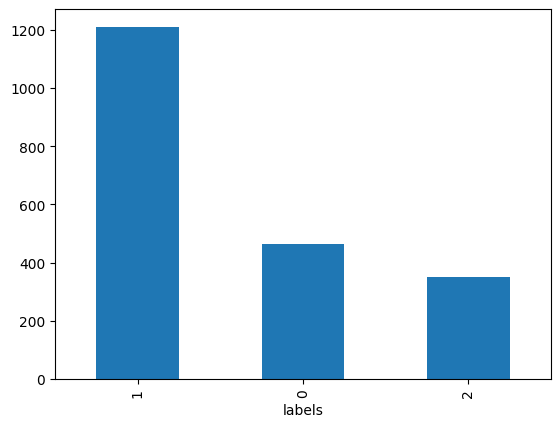

In [4]:
count = dataset_labeled['labels'].value_counts()
count.plot(kind='bar')

Max length will be set as 128. It covers more than 95% of observations

In [5]:
%%capture --no-display
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
tweet_lengths = [len(tokenizer.tokenize(tweet)) for tweet in dataset_labeled["text"]]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

In [6]:
print(f"95th percentile: {np.percentile(tweet_lengths, 95)}")  
print(f"Max tokens: {max(tweet_lengths)}")

95th percentile: 77.0
Max tokens: 221


# Evaluating Text Preprocessing Strategies for BERT Classification


To evaluate the impact of different text preprocessing techniques on BERT model performance using a systematic comparison approach.

#### Methodology
A baseline BERT model with default parameters was trained on each preprocessed version of the datasets. Due to class imbalance and the focus on positive/negative classification, the F1 score serves as the primary evaluation metric.

#### Preprocessing Strategies
The first part was training the model with different basic preprocessing strategies.
Then we evaluated six distinct preprocessing approaches, incrementally adding complexity to assess the impact of each step:

1. Raw text without any preprocessing
2. Removal of non-textual characters
3. Conversion of emojis to corresponding text + Removal of non-textual characters
4. Removal of non-textual characters + Spelling correction
5. Removal of non-textual characters + Spelling correction + Lemmatization
6. Removal of non-textual characters + Spelling correction + Lemmatization + Stopword removal

Model performance is evaluated using the F1 score, which provides a balanced measure of precision and recall, particularly important for our imbalanced dataset classification task.

In [7]:
tested_models = {}
tested_models['ROBERT'] = "sdadas/polish-roberta-base-v2"
tested_models['HERBERT']  = "allegro/herbert-base-cased"
tested_models['POLBERT']  = "dkleczek/bert-base-polish-cased-v1"
tested_models['MBERT'] = 'google-bert/bert-base-multilingual-cased'

In [8]:
def preprocess_tweet(tweet):
    tweet = re.sub(r'http\S+|www\S+|https\S+', ' ', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'@\w+|#\w+', ' ', tweet)
    tweet = re.sub(r'\$\w+', ' ', tweet)
    # Replace underscores with space
    tweet = re.sub(r'_', ' ', tweet)
    # Changed \w to use explicit character ranges instead
    tweet = re.sub(r'[^a-zA-ZĄąĆćĘęŁłŃńÓóŚśŹźŻż0-9\s?!]', ' ', tweet)
    tweet = re.sub(r'(.)\1+', r'\1', tweet)
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

In [9]:
#Removing http
def preprocess_tweet_https(tweet):
    tweet = re.sub(r'http\S+|www\S+|https\S+', ' ', tweet, flags=re.MULTILINE)
    return tweet

#Removing hashtags
def preprocess_tweet_hashtag(tweet):
    tweet = re.sub(r'#\w+', ' ', tweet)
    return tweet

#Removing mentions
def preprocess_tweet_mention(tweet):
    tweet = re.sub(r'@\w+', ' ', tweet)
    return tweet

#Removing cashtag
def preprocess_tweet_cashtag(tweet):
    tweet = re.sub(r'\$\w+', ' ', tweet)
    return tweet

#Removing all charatcters except polish letter and ? !
def preprocess_tweet_text(tweet):
    tweet = re.sub(r'[^a-zA-ZĄąĆćĘęŁłŃńÓóŚśŹźŻż0-9\s?!]', ' ', tweet)
    return tweet

#Removing repeated letters
def preprocess_tweet_rep(tweet):
    tweet = re.sub(r'(.)\1+', r'\1', tweet)
    return tweet

#Removing white spaces
def preprocess_tweet_norm(tweet):
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

#Normalizing caps
def preprocess_caps(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'(^|[.!?]\s+)(\w)', lambda m: m.group(1) + m.group(2).upper(), tweet)
    return tweet

def preprocess_tco(tweet):
    return re.sub(r"https?://t\.co/\S+", "", tweet).strip()

In [10]:
# Processing pipelines
strategies_processing_pipelines = {
    'No_processing': [],
    'No_processing_emoji': [
        replace_emoji
    ],
    'No_processing_spelling': [
        tool.correct
    ],
    'No_processing_spelling_lem': [
        tool.correct,
        lemmatize_text
    ],
    'No_processing_spelling_lem_sp': [
        preprocess_tweet,
        tool.correct,
        lemmatize_text,
        remove_stops
    ],
    'Basic_processing': [
        preprocess_tweet
    ],
    'Basic_processing_emoji': [
        preprocess_tweet,
        replace_emoji
    ],
    'Basic_processing_spelling': [
        preprocess_tweet,
        tool.correct
    ],
    'Basic_processing_spelling_lem': [
        preprocess_tweet,
        tool.correct,
        lemmatize_text
    ],
    'Basic_processing_spelling_lem_SP': [
        preprocess_tweet,
        tool.correct,
        lemmatize_text,
        remove_stops
    ]
}

basic_processing_pipelines = {
    'No_processing': [],
    'No_processing_emoji': [
        replace_emoji
    ],
    'No_processing_http': [
        preprocess_tweet_https
    ],
    'No_processing_hashtag': [
        preprocess_tweet_hashtag
    ],
    'No_processing_mention': [
        preprocess_tweet_mention
    ],
    'No_processing_cashtag': [
        preprocess_tweet_cashtag
    ],
    'No_processing__text': [
        preprocess_tweet_text
    ],
    'No_processing__rep': [
        preprocess_tweet_rep
    ],
    'No_processing_norm': [
        preprocess_tweet_norm
    ],
    'No_processing_caps': [
        preprocess_caps
    ]
}

#### Parameter setup

In [11]:
tested_models.keys()

dict_keys(['ROBERT', 'HERBERT', 'POLBERT', 'MBERT'])

In [12]:
processing_pipelines = basic_processing_pipelines
model = tested_models['HERBERT']
train_test_seed = 323
test_size = 0.20
model_seed = 12

In [15]:
datasets = transform_data(processing_pipelines = strategies_processing_pipelines,dataset=dataset_labeled, csv_dir='TrainingData/')

TrainingData/processed_data_No_processing.csv
TrainingData/processed_data_No_processing_emoji.csv
No_processing_spelling didn't found in directory. Applying function...
No_processing_spelling_lem didn't found in directory. Applying function...
No_processing_spelling_lem_sp didn't found in directory. Applying function...
Basic_processing didn't found in directory. Applying function...
Basic_processing_emoji didn't found in directory. Applying function...
Basic_processing_spelling didn't found in directory. Applying function...
Basic_processing_spelling_lem didn't found in directory. Applying function...
Basic_processing_spelling_lem_SP didn't found in directory. Applying function...


In [53]:
datasets = transform_data(processing_pipelines = processing_pipelines,dataset=dataset_labeled, csv_dir='TrainingData/')

TrainingData/processed_data_No_processing.csv
TrainingData/processed_data_No_processing_emoji.csv
TrainingData/processed_data_No_processing_http.csv
TrainingData/processed_data_No_processing_hashtag.csv
TrainingData/processed_data_No_processing_mention.csv
TrainingData/processed_data_No_processing_cashtag.csv
TrainingData/processed_data_No_processing__text.csv
TrainingData/processed_data_No_processing__rep.csv
TrainingData/processed_data_No_processing_norm.csv
TrainingData/processed_data_No_processing_caps.csv


In [54]:
tokenized_datasets = {}
for key, df in datasets.items():
    tokenized_datasets[key] = prepare_datasets(df = df, model = model, test_size=test_size, random_state=train_test_seed, max_length=128, column='text')

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/395 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/395 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/395 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/395 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/1577 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/395 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/395 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/395 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/395 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/395 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/395 [00:00<?, ? examples/s]

In [67]:
results = run_evaluation(tokenized_datasets = tokenized_datasets, model = model, train_test_seed = train_test_seed, model_seed = model_seed)
# Save results
results_df = pd.DataFrame(results)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_df.to_csv(rf"./preprocessing_comparison/preprocessing_comparison_preprocessing_{key}_{model[:4]}_{train_test_seed}_{timestamp}.csv", index=False)
print(f"\nComparison saved to preprocessing_comparison_preprocessing_{key}.csv")


Testing preprocessing variant: No_processing
Training model: allegro/herbert-base-cased


loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.950000,0.928541,0.582278,0.263285,0.433694,0.000000,0.734300,0.055556
2,0.701600,0.638705,0.736709,0.698917,0.736041,0.740741,0.784580,0.571429
3,0.526000,0.586370,0.762025,0.719139,0.760130,0.768473,0.813187,0.575758


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.1, Unnamed: 0.2. If Unnamed: 0.1, Unnamed: 0.2 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 395
  Batch size = 32
Saving model checkpoint to ./results_No_processing_allegro/herbert-base-cased_323\checkpoint-99
Configuration saved in ./results_No_processing_allegro/herbert-base-cased_323\checkpoint-99\config.json
Model weights saved in ./results_No_processing_allegro/herbert-base-cased_323\checkpoint-99\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.1, Unnamed: 0.2. If Unnamed: 0.1, Unnamed: 0.2 are not expected by `BertFo

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Saved misclassified examples to ./errors/misclassified_alle_323_No_processing_20250524_210333.csv
[{'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing', 'accuracy': 0.7620253164556962, 'macro_f1': 0.7191390984494433, 'weighted_f1': 0.7601303686855848, 'neutral_f1': 0.768472906403941, 'positive_f1': 0.8131868131868133, 'negative_f1': 0.5757575757575757, 'epochs': 3.0}]

Testing preprocessing variant: No_processing_emoji
Training model: allegro/herbert-base-cased


loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.939000,0.929159,0.594937,0.306984,0.459792,0.000000,0.741463,0.179487
2,0.707100,0.653749,0.726582,0.646586,0.713140,0.747664,0.795699,0.396396
3,0.496100,0.622997,0.751899,0.693730,0.746491,0.739583,0.817797,0.523810


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.1, Unnamed: 0.2. If Unnamed: 0.1, Unnamed: 0.2 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 395
  Batch size = 32
Saving model checkpoint to ./results_No_processing_emoji_allegro/herbert-base-cased_323\checkpoint-99
Configuration saved in ./results_No_processing_emoji_allegro/herbert-base-cased_323\checkpoint-99\config.json
Model weights saved in ./results_No_processing_emoji_allegro/herbert-base-cased_323\checkpoint-99\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.1, Unnamed: 0.2. If Unnamed: 0.1, Unnamed: 0.2 are not e

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Saved misclassified examples to ./errors/misclassified_alle_323_No_processing_emoji_20250524_212424.csv
[{'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing', 'accuracy': 0.7620253164556962, 'macro_f1': 0.7191390984494433, 'weighted_f1': 0.7601303686855848, 'neutral_f1': 0.768472906403941, 'positive_f1': 0.8131868131868133, 'negative_f1': 0.5757575757575757, 'epochs': 3.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_emoji', 'accuracy': 0.7518987341772152, 'macro_f1': 0.6937298224374495, 'weighted_f1': 0.7464908281484659, 'neutral_f1': 0.7395833333333333, 'positive_f1': 0.8177966101694915, 'negative_f1': 0.5238095238095238, 'epochs': 3.0}]

Testing preprocessing variant: No_processing_http
Training model: allegro/herbert-base-cased


loading weights file pytorch_model.bin from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\pytorch_model.bin
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoin

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.923400,0.907672,0.569620,0.241935,0.413434,0.000000,0.725806,0.000000
2,0.496000,0.607857,0.746835,0.689542,0.742504,0.751269,0.809422,0.507937


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.1, Unnamed: 0.2. If Unnamed: 0.1, Unnamed: 0.2 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 395
  Batch size = 32
Saving model checkpoint to ./results_No_processing_http_allegro/herbert-base-cased_323\checkpoint-99
Configuration saved in ./results_No_processing_http_allegro/herbert-base-cased_323\checkpoint-99\config.json
Model weights saved in ./results_No_processing_http_allegro/herbert-base-cased_323\checkpoint-99\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.1, Unnamed: 0.2. If Unnamed: 0.1, Unnamed: 0.2 are not expe

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Saved misclassified examples to ./errors/misclassified_alle_323_No_processing_http_20250524_214517.csv
[{'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing', 'accuracy': 0.7620253164556962, 'macro_f1': 0.7191390984494433, 'weighted_f1': 0.7601303686855848, 'neutral_f1': 0.768472906403941, 'positive_f1': 0.8131868131868133, 'negative_f1': 0.5757575757575757, 'epochs': 3.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_emoji', 'accuracy': 0.7518987341772152, 'macro_f1': 0.6937298224374495, 'weighted_f1': 0.7464908281484659, 'neutral_f1': 0.7395833333333333, 'positive_f1': 0.8177966101694915, 'negative_f1': 0.5238095238095238, 'epochs': 3.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_http', 'accuracy': 0.7468354430379747, 'macro_f1': 0.6895424616704195, 'weighted_f1': 0.7425038949644129, 'neutral_f1': 0.751269035532995, 'positive_f1': 0.8094218415417559, 'negative_f1': 0.507936507936508, 'epochs': 2.9746192893401

loading weights file pytorch_model.bin from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\pytorch_model.bin
Attempting to create safetensors variant
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFor

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.922900,0.860977,0.597468,0.346787,0.489229,0.129630,0.740000,0.170732
2,0.655500,0.586065,0.754430,0.711105,0.752996,0.732984,0.812095,0.588235
3,0.471600,0.566432,0.772152,0.735677,0.771506,0.770000,0.819383,0.617647


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.1, Unnamed: 0.2. If Unnamed: 0.1, Unnamed: 0.2 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 395
  Batch size = 32
Saving model checkpoint to ./results_No_processing_hashtag_allegro/herbert-base-cased_323\checkpoint-99
Configuration saved in ./results_No_processing_hashtag_allegro/herbert-base-cased_323\checkpoint-99\config.json
Model weights saved in ./results_No_processing_hashtag_allegro/herbert-base-cased_323\checkpoint-99\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.1, Unnamed: 0.2. If Unnamed: 0.1, Unnamed: 0.2 are

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Saved misclassified examples to ./errors/misclassified_alle_323_No_processing_hashtag_20250524_220617.csv
[{'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing', 'accuracy': 0.7620253164556962, 'macro_f1': 0.7191390984494433, 'weighted_f1': 0.7601303686855848, 'neutral_f1': 0.768472906403941, 'positive_f1': 0.8131868131868133, 'negative_f1': 0.5757575757575757, 'epochs': 3.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_emoji', 'accuracy': 0.7518987341772152, 'macro_f1': 0.6937298224374495, 'weighted_f1': 0.7464908281484659, 'neutral_f1': 0.7395833333333333, 'positive_f1': 0.8177966101694915, 'negative_f1': 0.5238095238095238, 'epochs': 3.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_http', 'accuracy': 0.7468354430379747, 'macro_f1': 0.6895424616704195, 'weighted_f1': 0.7425038949644129, 'neutral_f1': 0.751269035532995, 'positive_f1': 0.8094218415417559, 'negative_f1': 0.507936507936508, 'epochs': 2.9746192893

loading weights file pytorch_model.bin from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\pytorch_model.bin
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoin

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.845400,0.835535,0.630380,0.442342,0.558347,0.371429,0.753065,0.202532
2,0.652300,0.615217,0.744304,0.669091,0.728015,0.743961,0.803313,0.460000
3,0.479000,0.618248,0.746835,0.679414,0.734557,0.711340,0.813142,0.513761


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.1, Unnamed: 0.2. If Unnamed: 0.1, Unnamed: 0.2 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 395
  Batch size = 32
Saving model checkpoint to ./results_No_processing_mention_allegro/herbert-base-cased_323\checkpoint-99
Configuration saved in ./results_No_processing_mention_allegro/herbert-base-cased_323\checkpoint-99\config.json
Model weights saved in ./results_No_processing_mention_allegro/herbert-base-cased_323\checkpoint-99\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.1, Unnamed: 0.2. If Unnamed: 0.1, Unnamed: 0.2 are

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Saved misclassified examples to ./errors/misclassified_alle_323_No_processing_mention_20250524_222719.csv
[{'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing', 'accuracy': 0.7620253164556962, 'macro_f1': 0.7191390984494433, 'weighted_f1': 0.7601303686855848, 'neutral_f1': 0.768472906403941, 'positive_f1': 0.8131868131868133, 'negative_f1': 0.5757575757575757, 'epochs': 3.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_emoji', 'accuracy': 0.7518987341772152, 'macro_f1': 0.6937298224374495, 'weighted_f1': 0.7464908281484659, 'neutral_f1': 0.7395833333333333, 'positive_f1': 0.8177966101694915, 'negative_f1': 0.5238095238095238, 'epochs': 3.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_http', 'accuracy': 0.7468354430379747, 'macro_f1': 0.6895424616704195, 'weighted_f1': 0.7425038949644129, 'neutral_f1': 0.751269035532995, 'positive_f1': 0.8094218415417559, 'negative_f1': 0.507936507936508, 'epochs': 2.9746192893

loading weights file pytorch_model.bin from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\pytorch_model.bin
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoin

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.921800,0.838982,0.660759,0.503326,0.613573,0.590000,0.764133,0.155844
2,0.639400,0.581391,0.754430,0.708196,0.753636,0.773869,0.810573,0.540146
3,0.434900,0.567797,0.769620,0.719654,0.767201,0.773196,0.829374,0.556391


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.1, Unnamed: 0.2. If Unnamed: 0.1, Unnamed: 0.2 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 395
  Batch size = 32
Saving model checkpoint to ./results_No_processing_cashtag_allegro/herbert-base-cased_323\checkpoint-99
Configuration saved in ./results_No_processing_cashtag_allegro/herbert-base-cased_323\checkpoint-99\config.json
Model weights saved in ./results_No_processing_cashtag_allegro/herbert-base-cased_323\checkpoint-99\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.1, Unnamed: 0.2. If Unnamed: 0.1, Unnamed: 0.2 are

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Saved misclassified examples to ./errors/misclassified_alle_323_No_processing_cashtag_20250524_224822.csv
[{'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing', 'accuracy': 0.7620253164556962, 'macro_f1': 0.7191390984494433, 'weighted_f1': 0.7601303686855848, 'neutral_f1': 0.768472906403941, 'positive_f1': 0.8131868131868133, 'negative_f1': 0.5757575757575757, 'epochs': 3.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_emoji', 'accuracy': 0.7518987341772152, 'macro_f1': 0.6937298224374495, 'weighted_f1': 0.7464908281484659, 'neutral_f1': 0.7395833333333333, 'positive_f1': 0.8177966101694915, 'negative_f1': 0.5238095238095238, 'epochs': 3.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_http', 'accuracy': 0.7468354430379747, 'macro_f1': 0.6895424616704195, 'weighted_f1': 0.7425038949644129, 'neutral_f1': 0.751269035532995, 'positive_f1': 0.8094218415417559, 'negative_f1': 0.507936507936508, 'epochs': 2.9746192893

loading weights file pytorch_model.bin from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\pytorch_model.bin
Attempting to create safetensors variant
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFor

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.946800,0.941648,0.584810,0.280303,0.443827,0.000000,0.737013,0.103896
2,0.710800,0.649401,0.746835,0.664116,0.730605,0.746114,0.816327,0.429907
3,0.516500,0.614207,0.759494,0.702879,0.753808,0.755102,0.821277,0.532258


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.1, Unnamed: 0.2. If Unnamed: 0.1, Unnamed: 0.2 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 395
  Batch size = 32
Saving model checkpoint to ./results_No_processing__text_allegro/herbert-base-cased_323\checkpoint-99
Configuration saved in ./results_No_processing__text_allegro/herbert-base-cased_323\checkpoint-99\config.json
Model weights saved in ./results_No_processing__text_allegro/herbert-base-cased_323\checkpoint-99\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.1, Unnamed: 0.2. If Unnamed: 0.1, Unnamed: 0.2 are not e

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Saved misclassified examples to ./errors/misclassified_alle_323_No_processing__text_20250524_230936.csv
[{'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing', 'accuracy': 0.7620253164556962, 'macro_f1': 0.7191390984494433, 'weighted_f1': 0.7601303686855848, 'neutral_f1': 0.768472906403941, 'positive_f1': 0.8131868131868133, 'negative_f1': 0.5757575757575757, 'epochs': 3.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_emoji', 'accuracy': 0.7518987341772152, 'macro_f1': 0.6937298224374495, 'weighted_f1': 0.7464908281484659, 'neutral_f1': 0.7395833333333333, 'positive_f1': 0.8177966101694915, 'negative_f1': 0.5238095238095238, 'epochs': 3.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_http', 'accuracy': 0.7468354430379747, 'macro_f1': 0.6895424616704195, 'weighted_f1': 0.7425038949644129, 'neutral_f1': 0.751269035532995, 'positive_f1': 0.8094218415417559, 'negative_f1': 0.507936507936508, 'epochs': 2.974619289340

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification 

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.945500,0.928083,0.589873,0.297104,0.453720,0.000000,0.739414,0.151899
2,0.724800,0.632543,0.739241,0.655948,0.724277,0.758621,0.809224,0.400000
3,0.519200,0.592641,0.769620,0.722111,0.767089,0.776119,0.825328,0.564885


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.1, Unnamed: 0.2. If Unnamed: 0.1, Unnamed: 0.2 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 395
  Batch size = 32
Saving model checkpoint to ./results_No_processing__rep_allegro/herbert-base-cased_323\checkpoint-99
Configuration saved in ./results_No_processing__rep_allegro/herbert-base-cased_323\checkpoint-99\config.json
Model weights saved in ./results_No_processing__rep_allegro/herbert-base-cased_323\checkpoint-99\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.1, Unnamed: 0.2. If Unnamed: 0.1, Unnamed: 0.2 are not expe

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Saved misclassified examples to ./errors/misclassified_alle_323_No_processing__rep_20250524_233034.csv
[{'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing', 'accuracy': 0.7620253164556962, 'macro_f1': 0.7191390984494433, 'weighted_f1': 0.7601303686855848, 'neutral_f1': 0.768472906403941, 'positive_f1': 0.8131868131868133, 'negative_f1': 0.5757575757575757, 'epochs': 3.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_emoji', 'accuracy': 0.7518987341772152, 'macro_f1': 0.6937298224374495, 'weighted_f1': 0.7464908281484659, 'neutral_f1': 0.7395833333333333, 'positive_f1': 0.8177966101694915, 'negative_f1': 0.5238095238095238, 'epochs': 3.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_http', 'accuracy': 0.7468354430379747, 'macro_f1': 0.6895424616704195, 'weighted_f1': 0.7425038949644129, 'neutral_f1': 0.751269035532995, 'positive_f1': 0.8094218415417559, 'negative_f1': 0.507936507936508, 'epochs': 2.9746192893401

loading weights file pytorch_model.bin from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\pytorch_model.bin
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoin

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.936700,0.922833,0.584810,0.280361,0.443380,0.000000,0.735818,0.105263
2,0.704000,0.615955,0.754430,0.687437,0.744286,0.762887,0.816667,0.482759
3,0.491500,0.593234,0.744304,0.686620,0.738100,0.756477,0.803383,0.500000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.1, Unnamed: 0.2. If Unnamed: 0.1, Unnamed: 0.2 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 395
  Batch size = 32
Saving model checkpoint to ./results_No_processing_norm_allegro/herbert-base-cased_323\checkpoint-99
Configuration saved in ./results_No_processing_norm_allegro/herbert-base-cased_323\checkpoint-99\config.json
Model weights saved in ./results_No_processing_norm_allegro/herbert-base-cased_323\checkpoint-99\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.1, Unnamed: 0.2. If Unnamed: 0.1, Unnamed: 0.2 are not expe

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Saved misclassified examples to ./errors/misclassified_alle_323_No_processing_norm_20250524_235134.csv
[{'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing', 'accuracy': 0.7620253164556962, 'macro_f1': 0.7191390984494433, 'weighted_f1': 0.7601303686855848, 'neutral_f1': 0.768472906403941, 'positive_f1': 0.8131868131868133, 'negative_f1': 0.5757575757575757, 'epochs': 3.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_emoji', 'accuracy': 0.7518987341772152, 'macro_f1': 0.6937298224374495, 'weighted_f1': 0.7464908281484659, 'neutral_f1': 0.7395833333333333, 'positive_f1': 0.8177966101694915, 'negative_f1': 0.5238095238095238, 'epochs': 3.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_http', 'accuracy': 0.7468354430379747, 'macro_f1': 0.6895424616704195, 'weighted_f1': 0.7425038949644129, 'neutral_f1': 0.751269035532995, 'positive_f1': 0.8094218415417559, 'negative_f1': 0.507936507936508, 'epochs': 2.9746192893401

loading weights file pytorch_model.bin from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\pytorch_model.bin
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoin

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.939200,0.908733,0.582278,0.263426,0.434243,0.000000,0.735484,0.054795
2,0.712200,0.612081,0.767089,0.716886,0.764854,0.770833,0.827586,0.552239
3,0.512800,0.588403,0.767089,0.720871,0.766080,0.780000,0.823789,0.558824


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.1, Unnamed: 0.2. If Unnamed: 0.1, Unnamed: 0.2 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 395
  Batch size = 32
Saving model checkpoint to ./results_No_processing_caps_allegro/herbert-base-cased_323\checkpoint-99
Configuration saved in ./results_No_processing_caps_allegro/herbert-base-cased_323\checkpoint-99\config.json
Model weights saved in ./results_No_processing_caps_allegro/herbert-base-cased_323\checkpoint-99\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.1, Unnamed: 0.2. If Unnamed: 0.1, Unnamed: 0.2 are not expe

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Saved misclassified examples to ./errors/misclassified_alle_323_No_processing_caps_20250525_001231.csv
[{'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing', 'accuracy': 0.7620253164556962, 'macro_f1': 0.7191390984494433, 'weighted_f1': 0.7601303686855848, 'neutral_f1': 0.768472906403941, 'positive_f1': 0.8131868131868133, 'negative_f1': 0.5757575757575757, 'epochs': 3.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_emoji', 'accuracy': 0.7518987341772152, 'macro_f1': 0.6937298224374495, 'weighted_f1': 0.7464908281484659, 'neutral_f1': 0.7395833333333333, 'positive_f1': 0.8177966101694915, 'negative_f1': 0.5238095238095238, 'epochs': 3.0}, {'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing_http', 'accuracy': 0.7468354430379747, 'macro_f1': 0.6895424616704195, 'weighted_f1': 0.7425038949644129, 'neutral_f1': 0.751269035532995, 'positive_f1': 0.8094218415417559, 'negative_f1': 0.507936507936508, 'epochs': 2.9746192893401

In [20]:
datasets = transform_data(processing_pipelines = processing_pipelines,dataset=dataset_labeled, csv_dir='TrainingData/')
datasets_test = {}
datasets_test['No_processing'] = datasets['No_processing']
datasets_test['No_processing'] = datasets['No_processing_emoji']

for seed in [470, 432, 122]:
    print(f"\n{'='*40}")
    print(f"Testing seed: {seed}")
    train_test_seed = seed
    model_seed = seed
    for model in tested_models.values():
        tokenized_datasets = {}
        print(f"\n{'='*40}")
        print(f"Testing model: {model}")

        for key, df in datasets_test.items():
            tokenized_datasets[key] = prepare_datasets(df = df, model = model, test_size=test_size, random_state=train_test_seed, max_length=128, column='text')

        results = run_evaluation(tokenized_datasets = tokenized_datasets, model = model, train_test_seed = train_test_seed, model_seed = model_seed)
        # Save results
        results_df = pd.DataFrame(results)
        results_df['seed'] = seed
        
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        results_df.to_csv(rf"./preprocessing_comparison/preprocessing_comparison_model_{model[:4]}_{train_test_seed}_{timestamp}.csv", index=False)
        print(f"\nComparison saved to preprocessing_comparison_model_{model[:4]}.csv")

TrainingData/processed_data_No_processing.csv
TrainingData/processed_data_No_processing_emoji.csv
TrainingData/processed_data_No_processing_http.csv
TrainingData/processed_data_No_processing_hashtag.csv
TrainingData/processed_data_No_processing_mention.csv
TrainingData/processed_data_No_processing_cashtag.csv
TrainingData/processed_data_No_processing__text.csv
TrainingData/processed_data_No_processing__rep.csv
TrainingData/processed_data_No_processing_norm.csv
TrainingData/processed_data_No_processing_caps.csv

Testing seed: 470

Testing model: sdadas/polish-roberta-base-v2


loading file vocab.json from cache at None
loading file merges.txt from cache at None
loading file tokenizer.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\special_tokens_map.json
loading file tokenizer_config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\tokenizer_config.json
loading file chat_template.jinja from cache at None


Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

loading file vocab.json from cache at None
loading file merges.txt from cache at None
loading file tokenizer.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\special_tokens_map.json
loading file tokenizer_config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\tokenizer_config.json
loading file chat_template.jinja from cache at None


Map:   0%|          | 0/395 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\config.json
Model config RobertaConfig {
  "_name_or_path": "sdadas/polish-roberta-base-v2",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "tran


Testing preprocessing variant: No_processing
Training model: sdadas/polish-roberta-base-v2


Some weights of the model checkpoint at sdadas/polish-roberta-base-v2 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at sdadas/polish-roberta-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifi

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.968000,0.717029,0.721519,0.531585,0.668893,0.523810,0.820946,0.250000
2,0.653200,0.598528,0.772152,0.687500,0.763102,0.687898,0.846300,0.528302
3,0.476500,0.581064,0.772152,0.712441,0.771311,0.696203,0.837945,0.603175


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unnamed: 0.2, Unnamed: 0.1 are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 395
  Batch size = 32
Saving model checkpoint to ./results/results_No_processing_sdadas/polish-roberta-base-v2_470\checkpoint-99
Configuration saved in ./results/results_No_processing_sdadas/polish-roberta-base-v2_470\checkpoint-99\config.json
Model weights saved in ./results/results_No_processing_sdadas/polish-roberta-base-v2_470\checkpoint-99\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unnamed: 0.2

loading file vocab.json from cache at None
loading file merges.txt from cache at None
loading file tokenizer.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\special_tokens_map.json
loading file tokenizer_config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\tokenizer_config.json
loading file chat_template.jinja from cache at None
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unnamed: 0.2, Unnamed: 0.1 are not expected by `Rob

Saved misclassified examples to ./errors/misclassified_sdad_470_No_processing_20250525_130948.csv
[{'model': 'sdadas/polish-roberta-base-v2', 'preprocessing': 'No_processing', 'accuracy': 0.7721518987341772, 'macro_f1': 0.7124405996172644, 'weighted_f1': 0.7713108899526905, 'neutral_f1': 0.6962025316455697, 'positive_f1': 0.8379446640316205, 'negative_f1': 0.6031746031746031, 'epochs': 3.0}]

Comparison saved to preprocessing_comparison_model_sdad.csv

Testing model: allegro/herbert-base-cased


loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/395 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca


Testing preprocessing variant: No_processing
Training model: allegro/herbert-base-cased


loading weights file pytorch_model.bin from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\pytorch_model.bin
Attempting to create safetensors variant
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFor

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.976800,0.823643,0.675949,0.432847,0.599829,0.357143,0.792144,0.149254
2,0.687400,0.591704,0.769620,0.690527,0.760250,0.676471,0.838590,0.556522
3,0.460300,0.559156,0.789873,0.740939,0.791833,0.761905,0.845528,0.615385


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unnamed: 0.2, Unnamed: 0.1 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 395
  Batch size = 32
Saving model checkpoint to ./results/results_No_processing_allegro/herbert-base-cased_470\checkpoint-99
Configuration saved in ./results/results_No_processing_allegro/herbert-base-cased_470\checkpoint-99\config.json
Model weights saved in ./results/results_No_processing_allegro/herbert-base-cased_470\checkpoint-99\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unnamed: 0.2, Unnamed: 0.1 are

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Saved misclassified examples to ./errors/misclassified_alle_470_No_processing_20250525_132824.csv
[{'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing', 'accuracy': 0.789873417721519, 'macro_f1': 0.7409392775246434, 'weighted_f1': 0.7918330511723534, 'neutral_f1': 0.761904761904762, 'positive_f1': 0.8455284552845528, 'negative_f1': 0.6153846153846154, 'epochs': 3.0}]

Comparison saved to preprocessing_comparison_model_alle.csv

Testing model: dkleczek/bert-base-polish-cased-v1


tokenizer_config.json:   0%|          | 0.00/30.0 [00:00<?, ?B/s]

e:\Project_clean\PolishTweetsClassification\.venv\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed744e81ebd16cf099b5c64c40688bc3e6ace67\config.json
Model config BertConfig {
  "_name_or_path": "dkleczek/bert-base-polish-cased-v1",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 60000
}



vocab.txt:   0%|          | 0.00/489k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

loading file vocab.txt from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed744e81ebd16cf099b5c64c40688bc3e6ace67\vocab.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed744e81ebd16cf099b5c64c40688bc3e6ace67\special_tokens_map.json
loading file tokenizer_config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed744e81ebd16cf099b5c64c40688bc3e6ace67\tokenizer_config.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed744e81ebd16cf099b5c64c40688bc3e6ace67\config.json
Model config BertConfig {
  "_name_or_path": "dkleczek/bert-b

Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed744e81ebd16cf099b5c64c40688bc3e6ace67\config.json
Model config BertConfig {
  "_name_or_path": "dkleczek/bert-base-polish-cased-v1",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 60000
}

loading file vocab.txt from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed7

Map:   0%|          | 0/395 [00:00<?, ? examples/s]


Testing preprocessing variant: No_processing
Training model: dkleczek/bert-base-polish-cased-v1


loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed744e81ebd16cf099b5c64c40688bc3e6ace67\config.json
Model config BertConfig {
  "_name_or_path": "dkleczek/bert-base-polish-cased-v1",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "v

pytorch_model.bin:   0%|          | 0.00/531M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed744e81ebd16cf099b5c64c40688bc3e6ace67\pytorch_model.bin
Some weights of the model checkpoint at dkleczek/bert-base-polish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the c

model.safetensors:   0%|          | 0.00/531M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.888300,0.726090,0.708861,0.608793,0.706744,0.616216,0.813765,0.396396
2,0.563400,0.633252,0.739241,0.656241,0.739057,0.658065,0.830040,0.480620
3,0.292800,0.657391,0.749367,0.666953,0.748501,0.666667,0.838323,0.495868


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unnamed: 0.2, Unnamed: 0.1 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 395
  Batch size = 32
Saving model checkpoint to ./results/results_No_processing_dkleczek/bert-base-polish-cased-v1_470\checkpoint-99
Configuration saved in ./results/results_No_processing_dkleczek/bert-base-polish-cased-v1_470\checkpoint-99\config.json
Model weights saved in ./results/results_No_processing_dkleczek/bert-base-polish-cased-v1_470\checkpoint-99\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unname

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed744e81ebd16cf099b5c64c40688bc3e6ace67\config.json
Model config BertConfig {
  "_name_or_path": "dkleczek/bert-base-polish-cased-v1",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 60000
}

loading file vocab.txt from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed7

Saved misclassified examples to ./errors/misclassified_dkle_470_No_processing_20250525_134754.csv
[{'model': 'dkleczek/bert-base-polish-cased-v1', 'preprocessing': 'No_processing', 'accuracy': 0.7493670886075949, 'macro_f1': 0.6669525961850403, 'weighted_f1': 0.7485011982520992, 'neutral_f1': 0.6666666666666667, 'positive_f1': 0.8383233532934131, 'negative_f1': 0.49586776859504134, 'epochs': 3.0}]

Comparison saved to preprocessing_comparison_model_dkle.csv

Testing model: google-bert/bert-base-multilingual-cased


loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--google-bert--bert-base-multilingual-cased\snapshots\3f076fdb1ab68d5b2880cb87a0886f315b8146f8\config.json
Model config BertConfig {
  "_name_or_path": "google-bert/bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  

Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--google-bert--bert-base-multilingual-cased\snapshots\3f076fdb1ab68d5b2880cb87a0886f315b8146f8\config.json
Model config BertConfig {
  "_name_or_path": "google-bert/bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  

Map:   0%|          | 0/395 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--google-bert--bert-base-multilingual-cased\snapshots\3f076fdb1ab68d5b2880cb87a0886f315b8146f8\config.json
Model config BertConfig {
  "_name_or_path": "google-bert/bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_hea


Testing preprocessing variant: No_processing
Training model: google-bert/bert-base-multilingual-cased


A pretrained model of type `BertForSequenceClassification` contains parameters that have been renamed internally (a few are listed below but more are present in the model):
* `bert.embeddings.LayerNorm.beta` -> `bert.embeddings.LayerNorm.bias`
* `bert.embeddings.LayerNorm.gamma` -> `bert.embeddings.LayerNorm.weight`
If you are using a model from the Hub, consider submitting a PR to adjust these weights and help future users.
Some weights of the model checkpoint at google-bert/bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initial

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.969300,0.835703,0.632911,0.258799,0.491391,0.000000,0.776398,0.000000
2,0.795500,0.781409,0.668354,0.521763,0.645789,0.357143,0.800738,0.407407
3,0.675300,0.774299,0.665823,0.560080,0.663255,0.402439,0.794466,0.483333


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unnamed: 0.2, Unnamed: 0.1 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 395
  Batch size = 32
Saving model checkpoint to ./results/results_No_processing_google-bert/bert-base-multilingual-cased_470\checkpoint-99
Configuration saved in ./results/results_No_processing_google-bert/bert-base-multilingual-cased_470\checkpoint-99\config.json
Model weights saved in ./results/results_No_processing_google-bert/bert-base-multilingual-cased_470\checkpoint-99\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnam

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--google-bert--bert-base-multilingual-cased\snapshots\3f076fdb1ab68d5b2880cb87a0886f315b8146f8\config.json
Model config BertConfig {
  "_name_or_path": "google-bert/bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  

Saved misclassified examples to ./errors/misclassified_goog_470_No_processing_20250525_140826.csv
[{'model': 'google-bert/bert-base-multilingual-cased', 'preprocessing': 'No_processing', 'accuracy': 0.6658227848101266, 'macro_f1': 0.5600795869618774, 'weighted_f1': 0.6632549531179006, 'neutral_f1': 0.40243902439024387, 'positive_f1': 0.7944664031620554, 'negative_f1': 0.4833333333333333, 'epochs': 3.0}]

Comparison saved to preprocessing_comparison_model_goog.csv

Testing seed: 432

Testing model: sdadas/polish-roberta-base-v2


loading file vocab.json from cache at None
loading file merges.txt from cache at None
loading file tokenizer.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\special_tokens_map.json
loading file tokenizer_config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\tokenizer_config.json
loading file chat_template.jinja from cache at None


Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

loading file vocab.json from cache at None
loading file merges.txt from cache at None
loading file tokenizer.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\special_tokens_map.json
loading file tokenizer_config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\tokenizer_config.json
loading file chat_template.jinja from cache at None


Map:   0%|          | 0/395 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\config.json
Model config RobertaConfig {
  "_name_or_path": "sdadas/polish-roberta-base-v2",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "tran


Testing preprocessing variant: No_processing
Training model: sdadas/polish-roberta-base-v2


Some weights of the model checkpoint at sdadas/polish-roberta-base-v2 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at sdadas/polish-roberta-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifi

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.866100,0.754829,0.688608,0.555984,0.647088,0.676190,0.769539,0.222222
2,0.683100,0.605734,0.741772,0.699009,0.737123,0.712871,0.793991,0.590164
3,0.445500,0.604830,0.749367,0.716859,0.748426,0.728155,0.795556,0.626866


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unnamed: 0.2, Unnamed: 0.1 are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 395
  Batch size = 32
Saving model checkpoint to ./results/results_No_processing_sdadas/polish-roberta-base-v2_432\checkpoint-99
Configuration saved in ./results/results_No_processing_sdadas/polish-roberta-base-v2_432\checkpoint-99\config.json
Model weights saved in ./results/results_No_processing_sdadas/polish-roberta-base-v2_432\checkpoint-99\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unnamed: 0.2

loading file vocab.json from cache at None
loading file merges.txt from cache at None
loading file tokenizer.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\special_tokens_map.json
loading file tokenizer_config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\tokenizer_config.json
loading file chat_template.jinja from cache at None
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unnamed: 0.2, Unnamed: 0.1 are not expected by `Rob

Saved misclassified examples to ./errors/misclassified_sdad_432_No_processing_20250525_143017.csv
[{'model': 'sdadas/polish-roberta-base-v2', 'preprocessing': 'No_processing', 'accuracy': 0.7493670886075949, 'macro_f1': 0.716858855667724, 'weighted_f1': 0.7484262078245045, 'neutral_f1': 0.7281553398058253, 'positive_f1': 0.7955555555555556, 'negative_f1': 0.626865671641791, 'epochs': 3.0}]

Comparison saved to preprocessing_comparison_model_sdad.csv

Testing model: allegro/herbert-base-cased


loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/395 [00:00<?, ? examples/s]


Testing preprocessing variant: No_processing
Training model: allegro/herbert-base-cased


loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.929200,0.786360,0.653165,0.483463,0.595606,0.539877,0.760512,0.150000
2,0.595800,0.661452,0.729114,0.713056,0.734461,0.717489,0.766917,0.654762
3,0.398100,0.630109,0.736709,0.710122,0.737949,0.706422,0.781609,0.642336


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unnamed: 0.2, Unnamed: 0.1 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 395
  Batch size = 32
Saving model checkpoint to ./results/results_No_processing_allegro/herbert-base-cased_432\checkpoint-99
Configuration saved in ./results/results_No_processing_allegro/herbert-base-cased_432\checkpoint-99\config.json
Model weights saved in ./results/results_No_processing_allegro/herbert-base-cased_432\checkpoint-99\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unnamed: 0.2, Unnamed: 0.1 are

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Saved misclassified examples to ./errors/misclassified_alle_432_No_processing_20250525_144947.csv
[{'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing', 'accuracy': 0.7291139240506329, 'macro_f1': 0.7130559957442185, 'weighted_f1': 0.7344607758824889, 'neutral_f1': 0.7174887892376682, 'positive_f1': 0.7669172932330828, 'negative_f1': 0.6547619047619048, 'epochs': 3.0}]

Comparison saved to preprocessing_comparison_model_alle.csv

Testing model: dkleczek/bert-base-polish-cased-v1


loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed744e81ebd16cf099b5c64c40688bc3e6ace67\config.json
Model config BertConfig {
  "_name_or_path": "dkleczek/bert-base-polish-cased-v1",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 60000
}



Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed744e81ebd16cf099b5c64c40688bc3e6ace67\config.json
Model config BertConfig {
  "_name_or_path": "dkleczek/bert-base-polish-cased-v1",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 60000
}

loading file vocab.txt from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed7

Map:   0%|          | 0/395 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed744e81ebd16cf099b5c64c40688bc3e6ace67\config.json
Model config BertConfig {
  "_name_or_path": "dkleczek/bert-base-polish-cased-v1",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "v


Testing preprocessing variant: No_processing
Training model: dkleczek/bert-base-polish-cased-v1


loading weights file pytorch_model.bin from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed744e81ebd16cf099b5c64c40688bc3e6ace67\pytorch_model.bin
Some weights of the model checkpoint at dkleczek/bert-base-polish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the c

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.846000,0.771715,0.665823,0.536063,0.626771,0.506494,0.771800,0.329897
2,0.553300,0.693940,0.716456,0.666938,0.713835,0.629213,0.792291,0.579310
3,0.289800,0.744219,0.701266,0.655823,0.699788,0.623116,0.772926,0.571429


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unnamed: 0.2, Unnamed: 0.1 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 395
  Batch size = 32
Saving model checkpoint to ./results/results_No_processing_dkleczek/bert-base-polish-cased-v1_432\checkpoint-99
Configuration saved in ./results/results_No_processing_dkleczek/bert-base-polish-cased-v1_432\checkpoint-99\config.json
Model weights saved in ./results/results_No_processing_dkleczek/bert-base-polish-cased-v1_432\checkpoint-99\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unname

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed744e81ebd16cf099b5c64c40688bc3e6ace67\config.json
Model config BertConfig {
  "_name_or_path": "dkleczek/bert-base-polish-cased-v1",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 60000
}

loading file vocab.txt from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed7

Saved misclassified examples to ./errors/misclassified_dkle_432_No_processing_20250525_150950.csv
[{'model': 'dkleczek/bert-base-polish-cased-v1', 'preprocessing': 'No_processing', 'accuracy': 0.7164556962025317, 'macro_f1': 0.6669383495101329, 'weighted_f1': 0.7138353070278224, 'neutral_f1': 0.6292134831460675, 'positive_f1': 0.7922912205567452, 'negative_f1': 0.5793103448275863, 'epochs': 3.0}]

Comparison saved to preprocessing_comparison_model_dkle.csv

Testing model: google-bert/bert-base-multilingual-cased


loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--google-bert--bert-base-multilingual-cased\snapshots\3f076fdb1ab68d5b2880cb87a0886f315b8146f8\config.json
Model config BertConfig {
  "_name_or_path": "google-bert/bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  

Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--google-bert--bert-base-multilingual-cased\snapshots\3f076fdb1ab68d5b2880cb87a0886f315b8146f8\config.json
Model config BertConfig {
  "_name_or_path": "google-bert/bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  

Map:   0%|          | 0/395 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--google-bert--bert-base-multilingual-cased\snapshots\3f076fdb1ab68d5b2880cb87a0886f315b8146f8\config.json
Model config BertConfig {
  "_name_or_path": "google-bert/bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_hea


Testing preprocessing variant: No_processing
Training model: google-bert/bert-base-multilingual-cased


Some weights of the model checkpoint at google-bert/bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-ber

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.924500,0.924458,0.574684,0.243301,0.419464,0.000000,0.729904,0.000000
2,0.765900,0.895059,0.625316,0.437477,0.565441,0.449438,0.761726,0.101266
3,0.677400,0.871176,0.622785,0.553213,0.616995,0.506787,0.722944,0.429907


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unnamed: 0.2, Unnamed: 0.1 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 395
  Batch size = 32
Saving model checkpoint to ./results/results_No_processing_google-bert/bert-base-multilingual-cased_432\checkpoint-99
Configuration saved in ./results/results_No_processing_google-bert/bert-base-multilingual-cased_432\checkpoint-99\config.json
Model weights saved in ./results/results_No_processing_google-bert/bert-base-multilingual-cased_432\checkpoint-99\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnam

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--google-bert--bert-base-multilingual-cased\snapshots\3f076fdb1ab68d5b2880cb87a0886f315b8146f8\config.json
Model config BertConfig {
  "_name_or_path": "google-bert/bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  

Saved misclassified examples to ./errors/misclassified_goog_432_No_processing_20250525_154009.csv
[{'model': 'google-bert/bert-base-multilingual-cased', 'preprocessing': 'No_processing', 'accuracy': 0.6227848101265823, 'macro_f1': 0.5532125317721799, 'weighted_f1': 0.6169951388523285, 'neutral_f1': 0.5067873303167421, 'positive_f1': 0.722943722943723, 'negative_f1': 0.4299065420560747, 'epochs': 3.0}]

Comparison saved to preprocessing_comparison_model_goog.csv

Testing seed: 122

Testing model: sdadas/polish-roberta-base-v2


loading file vocab.json from cache at None
loading file merges.txt from cache at None
loading file tokenizer.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\special_tokens_map.json
loading file tokenizer_config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\tokenizer_config.json
loading file chat_template.jinja from cache at None


Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

loading file vocab.json from cache at None
loading file merges.txt from cache at None
loading file tokenizer.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\special_tokens_map.json
loading file tokenizer_config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\tokenizer_config.json
loading file chat_template.jinja from cache at None


Map:   0%|          | 0/395 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\config.json
Model config RobertaConfig {
  "_name_or_path": "sdadas/polish-roberta-base-v2",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "tran


Testing preprocessing variant: No_processing
Training model: sdadas/polish-roberta-base-v2


Some weights of the model checkpoint at sdadas/polish-roberta-base-v2 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at sdadas/polish-roberta-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifi

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.984200,0.885795,0.632911,0.382839,0.539052,0.230769,0.761905,0.155844
2,0.685700,0.695255,0.721519,0.642469,0.711006,0.643678,0.801587,0.482143
3,0.509300,0.684814,0.718987,0.654839,0.716270,0.655367,0.797521,0.511628


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unnamed: 0.2, Unnamed: 0.1 are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 395
  Batch size = 32
Saving model checkpoint to ./results/results_No_processing_sdadas/polish-roberta-base-v2_122\checkpoint-99
Configuration saved in ./results/results_No_processing_sdadas/polish-roberta-base-v2_122\checkpoint-99\config.json
Model weights saved in ./results/results_No_processing_sdadas/polish-roberta-base-v2_122\checkpoint-99\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unnamed: 0.2

loading file vocab.json from cache at None
loading file merges.txt from cache at None
loading file tokenizer.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\special_tokens_map.json
loading file tokenizer_config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--sdadas--polish-roberta-base-v2\snapshots\de1a6641c65e5a774a50ec165e7544279f9da79f\tokenizer_config.json
loading file chat_template.jinja from cache at None
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unnamed: 0.2, Unnamed: 0.1 are not expected by `Rob

Saved misclassified examples to ./errors/misclassified_sdad_122_No_processing_20250525_160336.csv
[{'model': 'sdadas/polish-roberta-base-v2', 'preprocessing': 'No_processing', 'accuracy': 0.7189873417721518, 'macro_f1': 0.6548385999240623, 'weighted_f1': 0.7162701588619409, 'neutral_f1': 0.6553672316384181, 'positive_f1': 0.7975206611570249, 'negative_f1': 0.5116279069767442, 'epochs': 3.0}]

Comparison saved to preprocessing_comparison_model_sdad.csv

Testing model: allegro/herbert-base-cased


loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Map:   0%|          | 0/395 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca


Testing preprocessing variant: No_processing
Training model: allegro/herbert-base-cased


loading weights file pytorch_model.bin from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\pytorch_model.bin
Attempting to create safetensors variant
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFor

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.970400,0.846889,0.620253,0.335224,0.511980,0.188679,0.761438,0.055556
2,0.680000,0.737766,0.670886,0.617986,0.672811,0.569343,0.750524,0.534091
3,0.433900,0.677938,0.729114,0.674343,0.728507,0.707865,0.796646,0.518519


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unnamed: 0.2, Unnamed: 0.1 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 395
  Batch size = 32
Saving model checkpoint to ./results/results_No_processing_allegro/herbert-base-cased_122\checkpoint-99
Configuration saved in ./results/results_No_processing_allegro/herbert-base-cased_122\checkpoint-99\config.json
Model weights saved in ./results/results_No_processing_allegro/herbert-base-cased_122\checkpoint-99\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unnamed: 0.2, Unnamed: 0.1 are

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

Saved misclassified examples to ./errors/misclassified_alle_122_No_processing_20250525_163345.csv
[{'model': 'allegro/herbert-base-cased', 'preprocessing': 'No_processing', 'accuracy': 0.7291139240506329, 'macro_f1': 0.6743431297879746, 'weighted_f1': 0.728507266561651, 'neutral_f1': 0.7078651685393258, 'positive_f1': 0.7966457023060796, 'negative_f1': 0.5185185185185185, 'epochs': 3.0}]

Comparison saved to preprocessing_comparison_model_alle.csv

Testing model: dkleczek/bert-base-polish-cased-v1


loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed744e81ebd16cf099b5c64c40688bc3e6ace67\config.json
Model config BertConfig {
  "_name_or_path": "dkleczek/bert-base-polish-cased-v1",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 60000
}

loading file vocab.txt from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed7

Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed744e81ebd16cf099b5c64c40688bc3e6ace67\config.json
Model config BertConfig {
  "_name_or_path": "dkleczek/bert-base-polish-cased-v1",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 60000
}

loading file vocab.txt from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed7

Map:   0%|          | 0/395 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed744e81ebd16cf099b5c64c40688bc3e6ace67\config.json
Model config BertConfig {
  "_name_or_path": "dkleczek/bert-base-polish-cased-v1",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "v


Testing preprocessing variant: No_processing
Training model: dkleczek/bert-base-polish-cased-v1


loading weights file pytorch_model.bin from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed744e81ebd16cf099b5c64c40688bc3e6ace67\pytorch_model.bin
Attempting to create safetensors variant
Safetensors PR exists
Some weights of the model checkpoint at dkleczek/bert-base-polish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected i

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.862600,0.762818,0.660759,0.546013,0.638931,0.530387,0.763566,0.344086
2,0.499500,0.853501,0.637975,0.574545,0.643768,0.507463,0.742489,0.473684
3,0.269000,0.832036,0.698734,0.624304,0.694122,0.612717,0.787755,0.472441


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unnamed: 0.2, Unnamed: 0.1 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 395
  Batch size = 32
Saving model checkpoint to ./results/results_No_processing_dkleczek/bert-base-polish-cased-v1_122\checkpoint-99
Configuration saved in ./results/results_No_processing_dkleczek/bert-base-polish-cased-v1_122\checkpoint-99\config.json
Model weights saved in ./results/results_No_processing_dkleczek/bert-base-polish-cased-v1_122\checkpoint-99\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unname

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed744e81ebd16cf099b5c64c40688bc3e6ace67\config.json
Model config BertConfig {
  "_name_or_path": "dkleczek/bert-base-polish-cased-v1",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 60000
}

loading file vocab.txt from cache at C:\Users\szymo\.cache\huggingface\hub\models--dkleczek--bert-base-polish-cased-v1\snapshots\fed7

Saved misclassified examples to ./errors/misclassified_dkle_122_No_processing_20250525_170618.csv
[{'model': 'dkleczek/bert-base-polish-cased-v1', 'preprocessing': 'No_processing', 'accuracy': 0.6987341772151898, 'macro_f1': 0.6243042699761622, 'weighted_f1': 0.6941221594078693, 'neutral_f1': 0.6127167630057804, 'positive_f1': 0.7877551020408162, 'negative_f1': 0.4724409448818897, 'epochs': 3.0}]

Comparison saved to preprocessing_comparison_model_dkle.csv

Testing model: google-bert/bert-base-multilingual-cased


loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--google-bert--bert-base-multilingual-cased\snapshots\3f076fdb1ab68d5b2880cb87a0886f315b8146f8\config.json
Model config BertConfig {
  "_name_or_path": "google-bert/bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  

Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--google-bert--bert-base-multilingual-cased\snapshots\3f076fdb1ab68d5b2880cb87a0886f315b8146f8\config.json
Model config BertConfig {
  "_name_or_path": "google-bert/bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  

Map:   0%|          | 0/395 [00:00<?, ? examples/s]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--google-bert--bert-base-multilingual-cased\snapshots\3f076fdb1ab68d5b2880cb87a0886f315b8146f8\config.json
Model config BertConfig {
  "_name_or_path": "google-bert/bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_hea


Testing preprocessing variant: No_processing
Training model: google-bert/bert-base-multilingual-cased


Some weights of the model checkpoint at google-bert/bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-ber

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 0,F1 1,F1 2
1,0.982500,0.960591,0.612658,0.297233,0.484183,0.021277,0.760835,0.109589
2,0.846200,0.873402,0.607595,0.477845,0.585608,0.322148,0.744722,0.366667
3,0.680100,0.896651,0.607595,0.467909,0.581388,0.352201,0.743833,0.307692


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnamed: 0.1. If Unnamed: 0.2, Unnamed: 0.1 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 395
  Batch size = 32
Saving model checkpoint to ./results/results_No_processing_google-bert/bert-base-multilingual-cased_122\checkpoint-99
Configuration saved in ./results/results_No_processing_google-bert/bert-base-multilingual-cased_122\checkpoint-99\config.json
Model weights saved in ./results/results_No_processing_google-bert/bert-base-multilingual-cased_122\checkpoint-99\model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0.2, Unnam

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--google-bert--bert-base-multilingual-cased\snapshots\3f076fdb1ab68d5b2880cb87a0886f315b8146f8\config.json
Model config BertConfig {
  "_name_or_path": "google-bert/bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  

Saved misclassified examples to ./errors/misclassified_goog_122_No_processing_20250525_172635.csv
[{'model': 'google-bert/bert-base-multilingual-cased', 'preprocessing': 'No_processing', 'accuracy': 0.6075949367088608, 'macro_f1': 0.4778453355776264, 'weighted_f1': 0.5856084286653283, 'neutral_f1': 0.3221476510067114, 'positive_f1': 0.744721689059501, 'negative_f1': 0.36666666666666664, 'epochs': 3.0}]

Comparison saved to preprocessing_comparison_model_goog.csv
